# STAGE 2: MODELLING

Firstly, we start with the imports

In [1612]:
import warnings
warnings.filterwarnings('ignore')

In [1613]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
from matplotlib.lines import Line2D
from itertools import product
import plotly.graph_objs as go
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.linear_model import Lasso, Ridge, LinearRegression, HuberRegressor, ElasticNet
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from dateutil import rrule
from datetime import datetime

# LOADING THE DATA
Loading the saved Training, Validation and Test Data

In [1614]:
train_data = pd.read_csv('train_data.csv', index_col=0, parse_dates=True)
val_data = pd.read_csv('validation_data.csv', index_col=0, parse_dates=True)
test_data = pd.read_csv('test_data.csv', index_col=0, parse_dates=True)

In [1615]:
train_data.drop(['month', 'year', 'week_of_year','Month', 'Year'], axis=1, inplace=True)
val_data.drop(['month', 'year', 'week_of_year'], axis=1, inplace=True)
test_data.drop(['month', 'year', 'week_of_year'], axis=1, inplace=True)

In [1616]:
tstart_date = train_data.index.min()
tend_date = train_data.index.max()
print(f"Training Data starts from {tstart_date} and ends at {tend_date}")

vstart_date = val_data.index.min()
vend_date = val_data.index.max()
print(f"Validation Data starts from {vstart_date} and ends at {vend_date}")

testart_date = test_data.index.min()
teend_date = test_data.index.max()
print(f"Test Data starts from {testart_date} and ends at {teend_date}")

Training Data starts from 2010-01-01 00:00:00 and ends at 2019-12-31 00:00:00
Validation Data starts from 2019-12-31 01:00:00 and ends at 2022-12-31 00:00:00
Test Data starts from 2022-12-31 01:00:00 and ends at 2024-01-06 11:00:00


# THE BASELINE MODELS (SOLAR RADIATION AND WINDSPEED)
 
For the baseline models for Solar Radiation and Wind Speed, I decided to mirror the data from the last three years of my training set on my full three year validation set and evaluate the performance of this model. The first year of my validation dataset was a leap year, so I had to fix that by creating an extra day on my training dataset. 

In [1617]:
#Adding extra day(leap year) in last 3 years of training data before applying it as baseline
if '2017-02-29' not in train_data.index:
    # Extract data for February 28, 2017
    feb_28_data = train_data.loc['2017-02-28']

    # Create a new DataFrame for February 29, 2017
    feb_29_data = feb_28_data.copy()
    
    # Change the date in the index to February 29, 2017
    feb_29_data.index = feb_29_data.index + pd.DateOffset(days=1)

    # Concatenate the data before, the new February 29, and after into the training data
    before_feb_29 = train_data[:'2017-02-28']
    after_feb_29 = train_data['2017-03-01':]
    train_data = pd.concat([before_feb_29, feb_29_data, after_feb_29])


BASELINE MODEL AND PLOT FOR SOLAR RADIATION

In [1618]:
def measure_forecast_error(label, forecast):
    '''We will use this function to measure the performance of our baseline models'''
    print('MAE = %.2f (W/m2)' % mean_absolute_error(label, forecast))
    print('R2 = %.2f' % r2_score(label, forecast))
    
# Correctly define the start and end dates for the last 3 years of the training data 

# Last 3 years of training data 
start_last_year = pd.to_datetime('2016-12-31 01:00:00')
end_last_year = pd.to_datetime('2019-12-31 00:00:00')

# Extract the last 3 years from the training data
last_year_data = train_data.loc[start_last_year:end_last_year]

# Use the solar radiation data from the last 3 years of the training as predictions for the validation
predicted_solar_radiation = last_year_data['solarradiation'].values

# Calculate the MAE and R2 for the baseline model
measure_forecast_error(val_data['solarradiation'], predicted_solar_radiation)

MAE = 66.13 (W/m2)
R2 = 0.54


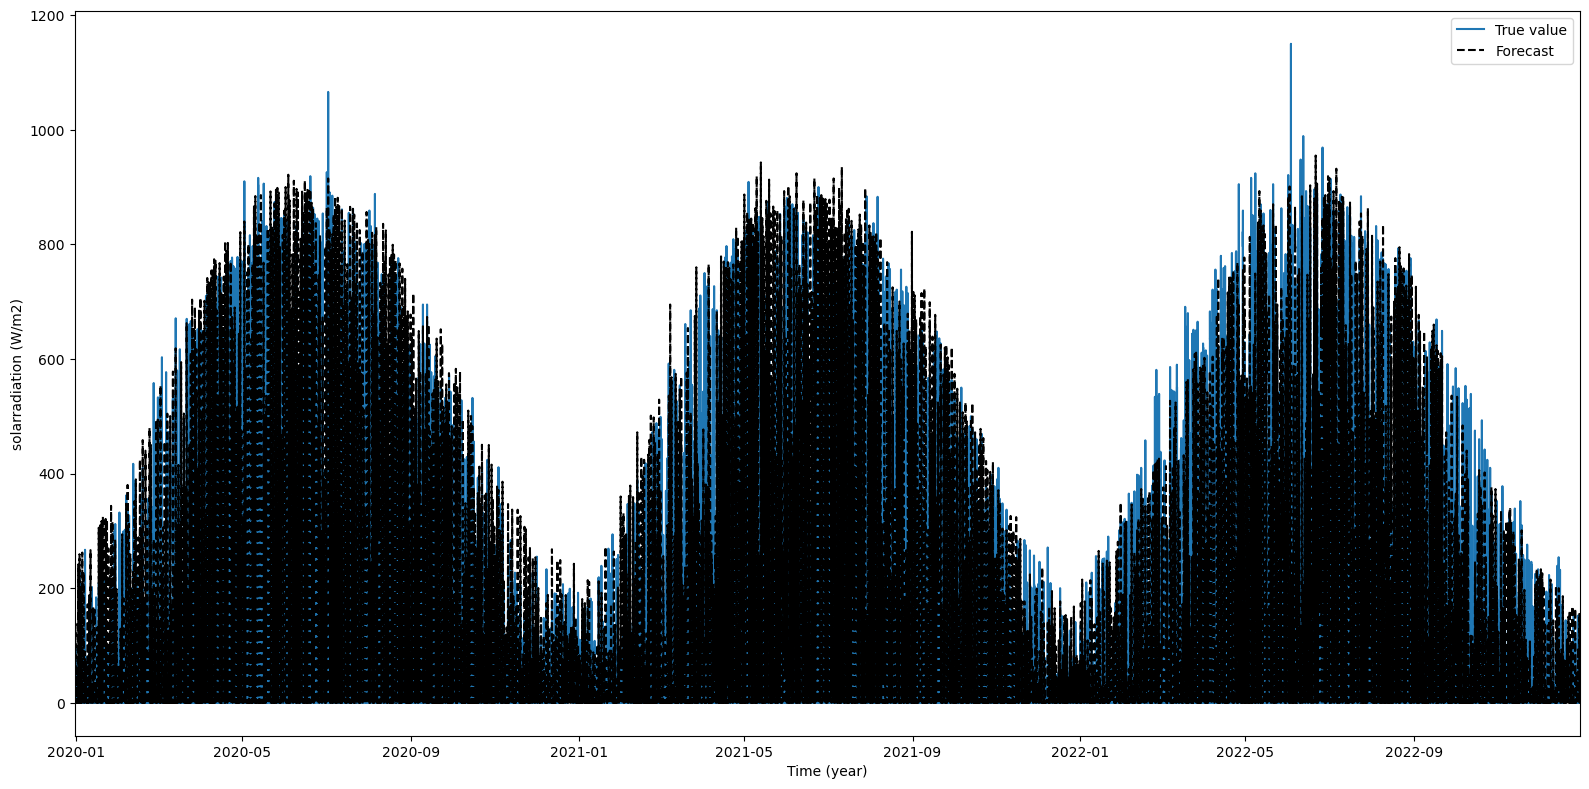

In [1619]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(val_data.index, val_data['solarradiation'], label='True value')
ax.plot(val_data.index, predicted_solar_radiation, '--', color='k', label='Forecast')
ax.set_xlabel('Time (year)')
ax.set_ylabel('solarradiation (W/m2)')
_=ax.set_xlim(val_data.index.min(), val_data.index.max())
plt.legend(loc='best')
plt.tight_layout()

R2=0.54: This value indicates that your model explains 54% of the variance in the solar radiation data. Given that solar radiation is seasonal, this isn't a surprising result. It suggests that by mirroring past seasonal trends, the model can capture over half of the variability in solar radiation.

MAE of 66.13 W/m²: This value tells us that the predictions are, on average, about 66.13 W/m² off from the actual solar radiation measurements.


BASELINE MODEL AND PLOT FOR WIND SPEED

In [1620]:
def measure_forecast_error2(label, forecast):
    '''We will use this function to measure the performance of our baseline models'''
    print('MAE = %.2f (mph)' % mean_absolute_error(label, forecast))
    print('R2 = %.2f' % r2_score(label, forecast))
    
# Correctly define the start and end dates for the last 3 years of the training data 

# Last 3 years of training data 
start_last_year2 = pd.to_datetime('2016-12-31 01:00:00')
end_last_year2 = pd.to_datetime('2019-12-31 00:00:00')

# Extract the last 3 years from the training data
last_year_data2 = train_data.loc[start_last_year2:end_last_year2]

# Use the wind speed data from the last 3 years of the training as predictions for the validation
predicted_windspeed = last_year_data2['windspeed'].values

# Calculate the MAE and R2 for the baseline model
measure_forecast_error2(val_data['windspeed'], predicted_windspeed)

MAE = 9.41 (mph)
R2 = -0.80


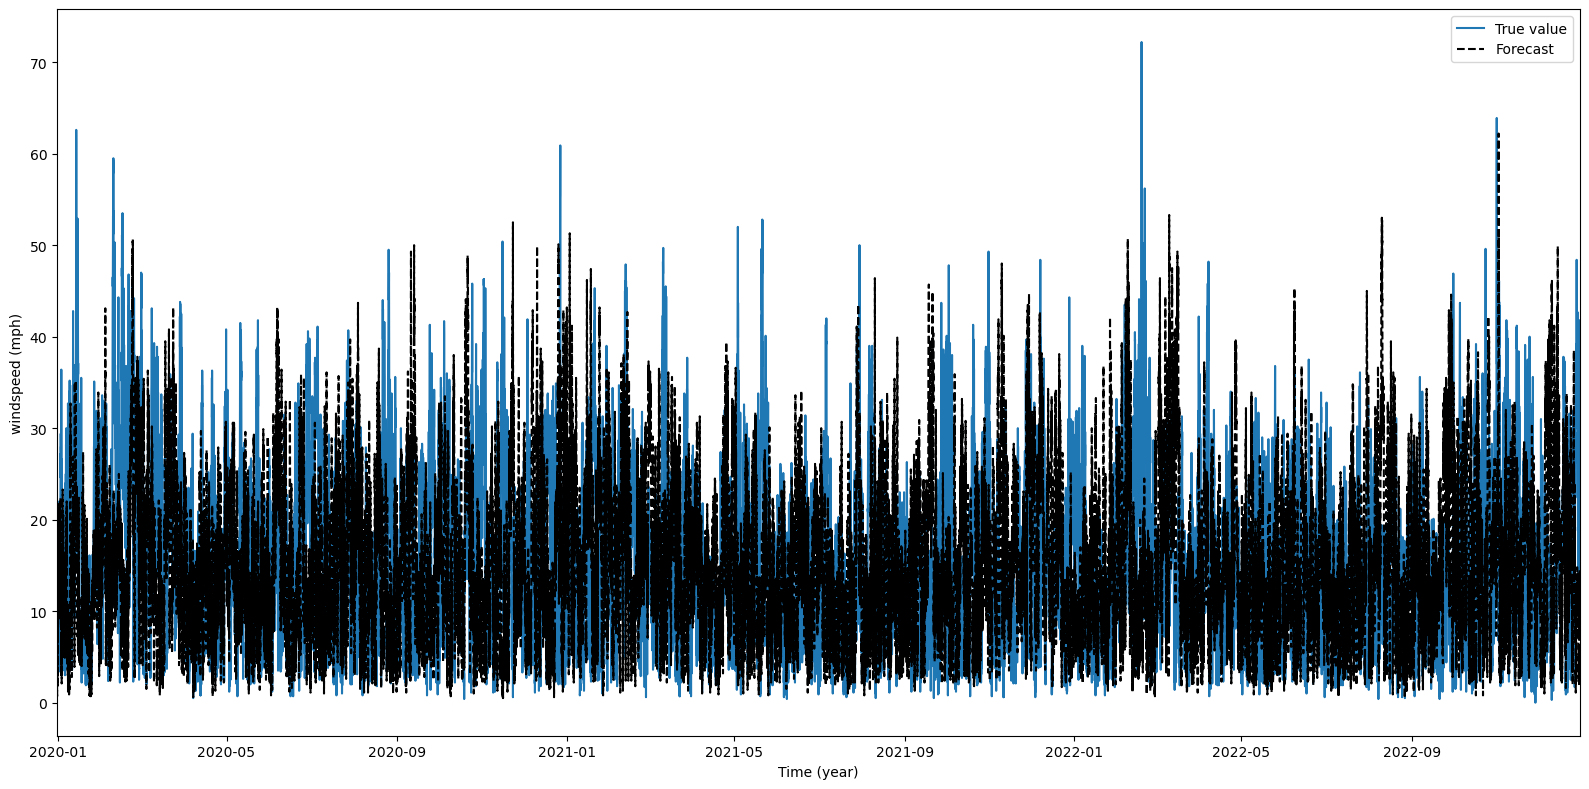

In [1621]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(val_data.index, val_data['windspeed'], label='True value')
ax.plot(val_data.index, predicted_windspeed, '--', color='k', label='Forecast')
ax.set_xlabel('Time (year)')
ax.set_ylabel('windspeed (mph)')
_=ax.set_xlim(val_data.index.min(), val_data.index.max())
plt.legend(loc='best')
plt.tight_layout()

R2=−0.80: An R2 score below 0, especially one as low as -0.80, indicates that the model performs really bad as a simple baseline model. This suggests that the model is not suitable at all for predicting wind speed, due to its irregular pattern (lack of seasonality).

MAE of 9.41 mph: The MAE indicates that the average prediction error for wind speed is 9.41 mph.

# MACHINE LEARNING MODEL FOR SOLAR RADIATION: Gradient Boosting Regressor (GBR)

These models can handle non-linear relationships and do not require the data to meet the assumptions necessary for linear models. They can also capture more complex patterns in the data.

In [1622]:
solarradiation_tr = train_data['solarradiation'].copy().to_frame()
solarradiation_val = val_data['solarradiation'].copy().to_frame()
solarradiation_test = test_data['solarradiation'].copy().to_frame() 

In [1623]:
forecast_horizon = 24
window_size = 240
# Adding lag features for solar radiation
for lag in range(window_size):
    solarradiation_tr[f'solarradiation_lag{lag}'] = solarradiation_tr['solarradiation'].shift(lag+1)
    solarradiation_val[f'solarradiation_lag{lag}'] = solarradiation_val['solarradiation'].shift(lag+1)
    solarradiation_test[f'solarradiation_lag{lag}'] = solarradiation_test['solarradiation'].shift(lag+1)

#Creating a label Y for values to be predicted
solarradiation_tr['y'] = solarradiation_tr['solarradiation'].shift(-forecast_horizon)
solarradiation_val['y'] = solarradiation_val['solarradiation'].shift(-forecast_horizon)
solarradiation_test['y'] = solarradiation_test['solarradiation'].shift(-forecast_horizon)

In [1624]:
# Drop any rows with NaN values created by lagging
solarradiation_tr.dropna(inplace=True)
solarradiation_val.dropna(inplace=True)
solarradiation_test.dropna(inplace=True)

In [1625]:
# For solar radiation predictions
X_train = solarradiation_tr.drop(['y'], axis=1)
y_train = solarradiation_tr['y']

X_val = solarradiation_val.drop(['y'], axis=1)
y_val = solarradiation_val['y']

X_test = solarradiation_test.drop(['y'], axis=1)
y_test = solarradiation_test['y']

TESTING THE PERFORMANCE OF THE MODEL ON THE VALIDATION DATASET


In [1626]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
measure_forecast_error(y_val, y_pred)

MAE = 46.08 (W/m2)
R2 = 0.78


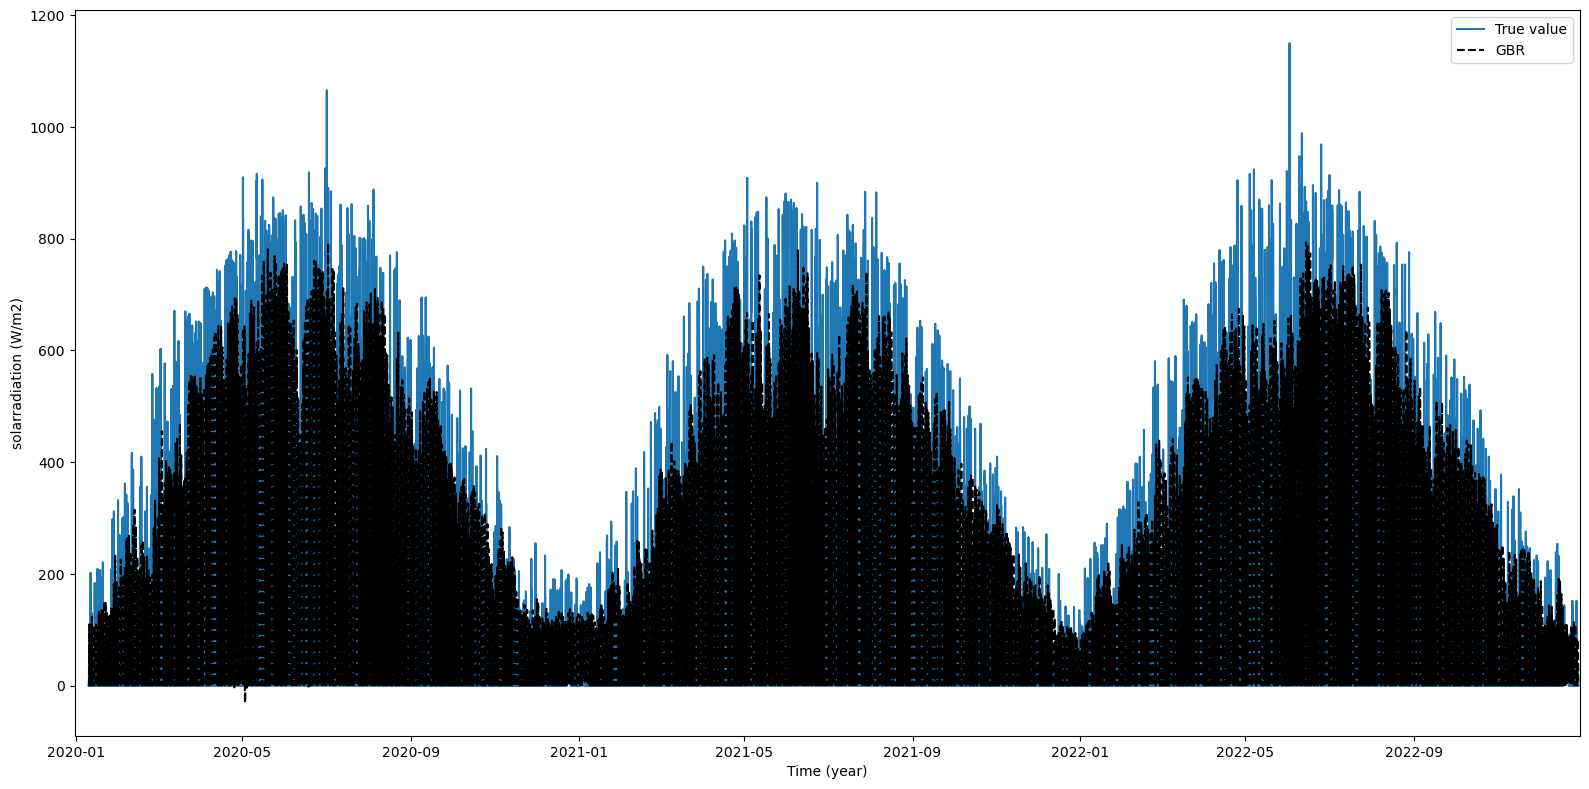

In [1627]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_val.index, y_val, label='True value')
ax.plot(y_val.index,  y_pred, '--', color='k', label='GBR')
ax.set_xlabel('Time (year)')
ax.set_ylabel('solarradiation (W/m2)')
_=ax.set_xlim(val_data.index.min(), val_data.index.max())
plt.legend(loc='best')
plt.tight_layout()

R2=0.78: This score indicates a good fit for the model, suggesting that it successfully captures about 78% of the variance in solar radiation in the validation dataset. This is a strong performance, showing a significant improvement over your initial baseline model.

MAE of 46.08 W/m²: The mean absolute error gives an average of how much the predictions deviate from the actual measurements. An MAE of 46.08 W/m² means that, on average, the model's predictions are off by this amount, which is an improvement from the baseline model.


TESTING THE PERFORMANCE OF THE MODEL ON THE TEST DATASET

In [1628]:
y_pred2 = model.predict(X_test)
measure_forecast_error(y_test, y_pred2)

MAE = 51.65 (W/m2)
R2 = 0.75


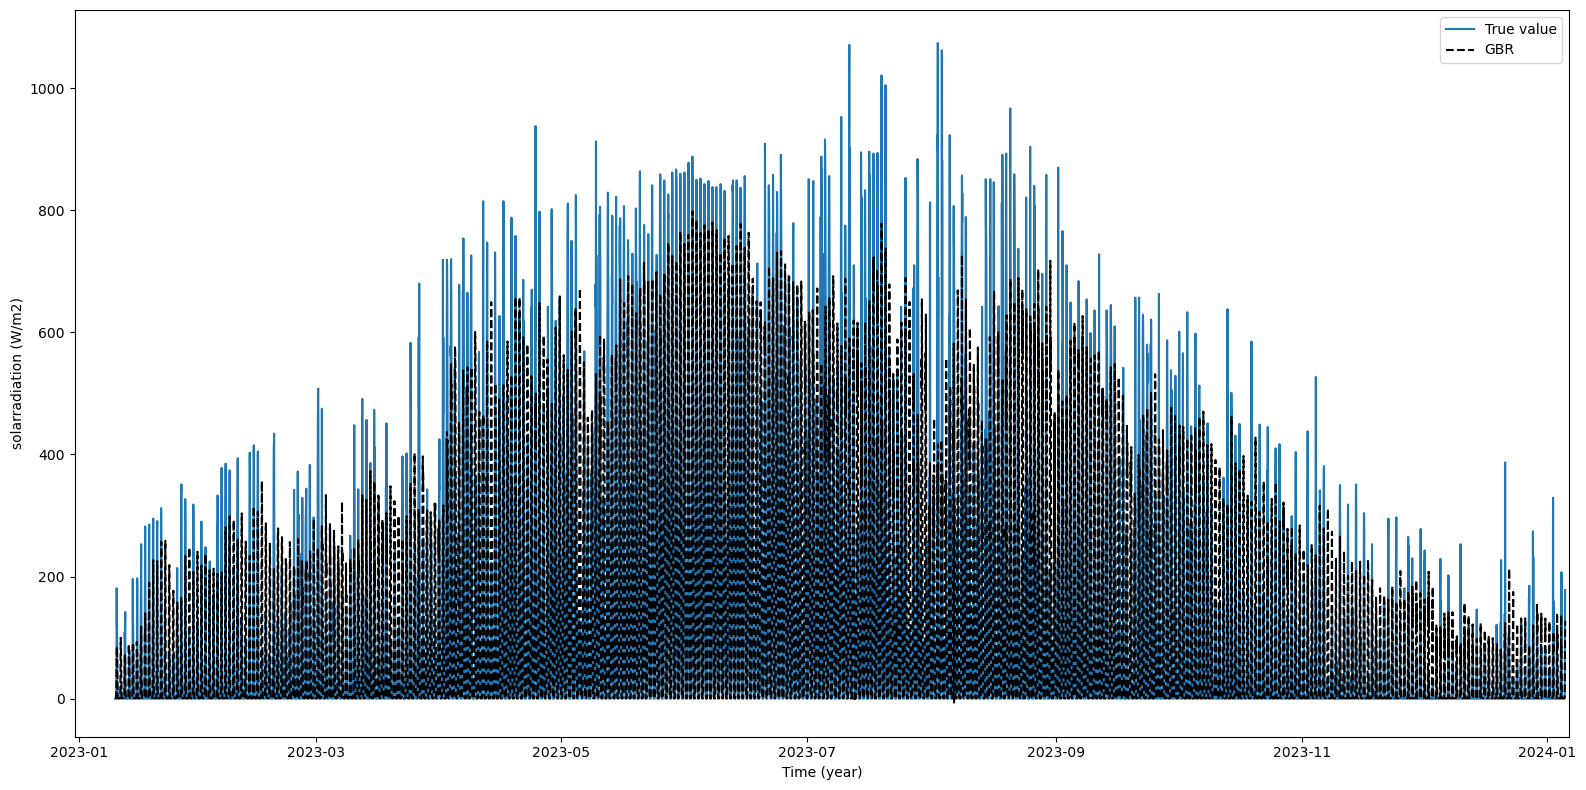

In [1629]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test.index, y_test, label='True value')
ax.plot(y_test.index,  y_pred2, '--', color='k', label='GBR')
ax.set_xlabel('Time (year)')
ax.set_ylabel('solarradiation (W/m2)')
_=ax.set_xlim(test_data.index.min(), test_data.index.max())
plt.legend(loc='best')
plt.tight_layout()

R2=0.75: The slight decrease in R2 when moving from validation to the test dataset (from 0.78 to 0.75) is typical in modeling processes as the test set is completely unseen during training. This score still indicates a good fit, suggesting the model generalizes well, although slightly less effectively than on the validation set.

MAE of 51.65 W/m²: The increase in MAE in the test set compared to the validation set (from 46.08 to 51.65 W/m²) is also expected as the test set might contain different or more challenging scenarios not captured during the model training.

No data for December 2022
January 2023      0.699968
February 2023     0.650220
March 2023        0.570398
April 2023        0.690388
May 2023          0.817430
June 2023         0.857868
July 2023         0.572243
August 2023       0.580075
September 2023    0.741730
October 2023      0.626165
November 2023     0.509298
December 2023     0.400913
January 2024      0.470068
dtype: float64


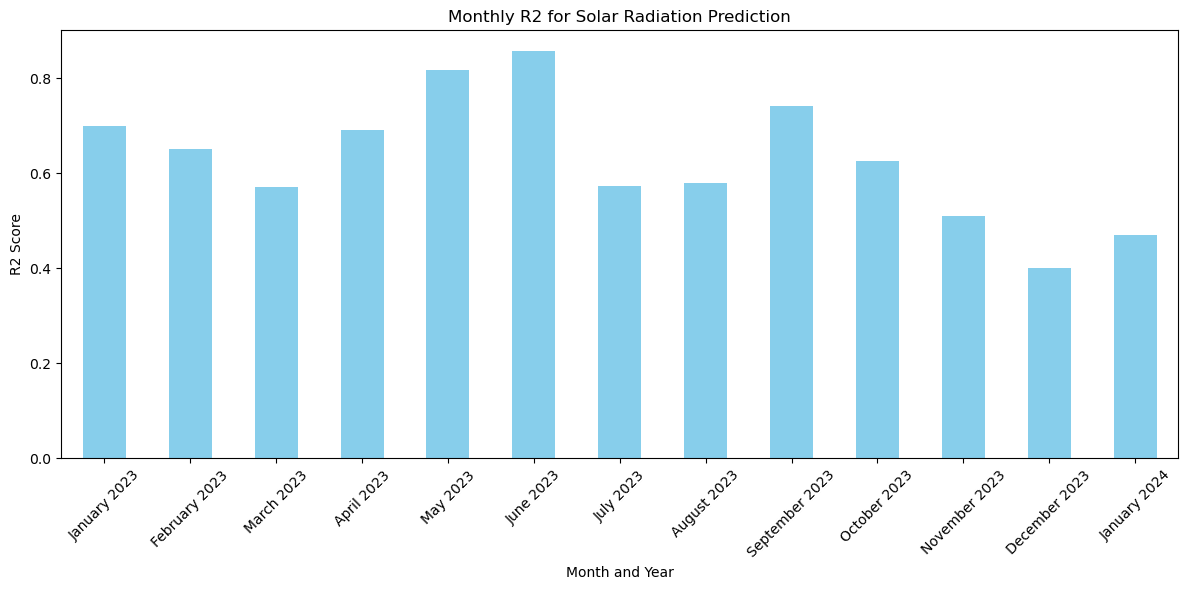

In [1630]:
# Create a list of monthly periods from the start to the end of your test data
monthly_periods = pd.period_range(start='2022-12-31 01:00:00', end='2024-01-06 11:00:00', freq='M')

# Dictionary to hold R2 for each month
monthly_r2 = {}

# Loop over each period
for period in monthly_periods:
    # Filter data for the current period
    month_data = solarradiation_test[solarradiation_test.index.to_period('M') == period]
    
    if not month_data.empty:
        # Assuming the target column is 'y' and is excluded from the prediction
        y_true = month_data['y']
        y_pred = model.predict(month_data.drop('y', axis=1))
        
        # Calculate and store R2
        monthly_r2[period.strftime('%B %Y')] = r2_score(y_true, y_pred)
    else:
        print(f"No data for {period.strftime('%B %Y')}")

# Convert to pandas Series for easy plotting and manipulation
monthly_r2_series = pd.Series(monthly_r2)
print(monthly_r2_series)

# Plotting
plt.figure(figsize=(12, 6))
monthly_r2_series.plot(kind='bar', color='skyblue')
plt.title('Monthly R2 for Solar Radiation Prediction')
plt.xlabel('Month and Year')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust subplots to give some more room for the labels
plt.show()

PREDICTING SOLAR RADIATION VALUES 24 HOURS IN ADVANCE

In [1631]:
solarradiation_test2 = test_data['solarradiation'].copy().to_frame()
forecast_horizon = 24
window_size = 240
for lag in range(window_size):
    solarradiation_test2[f'solarradiation_lag{lag}'] = solarradiation_test2['solarradiation'].shift(lag+1)

solarradiation_test2.dropna(inplace=True)
solarradiation_test2 ['Final_Solar_Pred'] = model.predict(solarradiation_test2)

solarradiation_test2 ['Final_Solar_Pred'].tail(48)

2024-01-04 12:00:00     76.155000
2024-01-04 13:00:00     84.874864
2024-01-04 14:00:00     59.321608
2024-01-04 15:00:00      8.579810
2024-01-04 16:00:00      0.953444
2024-01-04 17:00:00      0.953444
2024-01-04 18:00:00      0.953444
2024-01-04 19:00:00      0.953444
2024-01-04 20:00:00      0.953444
2024-01-04 21:00:00      0.953444
2024-01-04 22:00:00      0.953444
2024-01-04 23:00:00      0.953444
2024-01-05 00:00:00      0.953444
2024-01-05 01:00:00      0.953444
2024-01-05 02:00:00      0.953444
2024-01-05 03:00:00      0.953444
2024-01-05 04:00:00      0.953444
2024-01-05 05:00:00      0.953444
2024-01-05 06:00:00      0.953444
2024-01-05 07:00:00      0.953444
2024-01-05 08:00:00      3.327739
2024-01-05 09:00:00     23.334218
2024-01-05 10:00:00     81.315365
2024-01-05 11:00:00    127.615467
2024-01-05 12:00:00     93.368930
2024-01-05 13:00:00    102.852823
2024-01-05 14:00:00     72.280988
2024-01-05 15:00:00     17.628944
2024-01-05 16:00:00      3.767103
2024-01-05 17:

# MACHINE LEARNING MODEL FOR WIND SPEED: Ridge Regression Model 

In [1632]:
windspeed_tr = train_data['windspeed'].copy().to_frame()
windspeed_val = val_data['windspeed'].copy().to_frame()
windspeed_test = test_data['windspeed'].copy().to_frame() 

In [1633]:
forecast_horizon = 24
window_size = 380
 #Adding lag features for Windspeed
for lag in range(window_size):
    windspeed_tr[f'windspeed_lag{lag}'] = windspeed_tr['windspeed'].shift(lag+1)
    windspeed_val[f'windspeed_lag{lag}'] = windspeed_val['windspeed'].shift(lag+1)
    windspeed_test[f'windspeed_lag{lag}'] = windspeed_test['windspeed'].shift(lag+1)

#Creating a label Y for values to be predicted
windspeed_tr['y'] = windspeed_tr['windspeed'].shift(-forecast_horizon)
windspeed_val['y'] = windspeed_val['windspeed'].shift(-forecast_horizon)
windspeed_test['y'] = windspeed_test['windspeed'].shift(-forecast_horizon)

In [1634]:
# Drop any rows with NaN values created by lagging
windspeed_tr.dropna(inplace=True)
windspeed_val.dropna(inplace=True)
windspeed_test.dropna(inplace=True)

In [1635]:
# For wind speed predictions
X_trainW = windspeed_tr.drop(['y'], axis=1)
y_trainW = windspeed_tr['y']

X_valW = windspeed_val.drop(['y'], axis=1)
y_valW = windspeed_val['y']

X_testW = windspeed_test.drop(['y'], axis=1)
y_testW = windspeed_test['y']

TESTING THE PERFORMANCE OF THE MODEL ON THE VALIDATION DATASET

In [1636]:
model = Ridge(alpha=1.0, solver='auto')
model.fit(X_trainW, y_trainW)

y_predW = model.predict(X_valW)
measure_forecast_error2(y_valW, y_predW)

MAE = 6.31 (mph)
R2 = 0.18


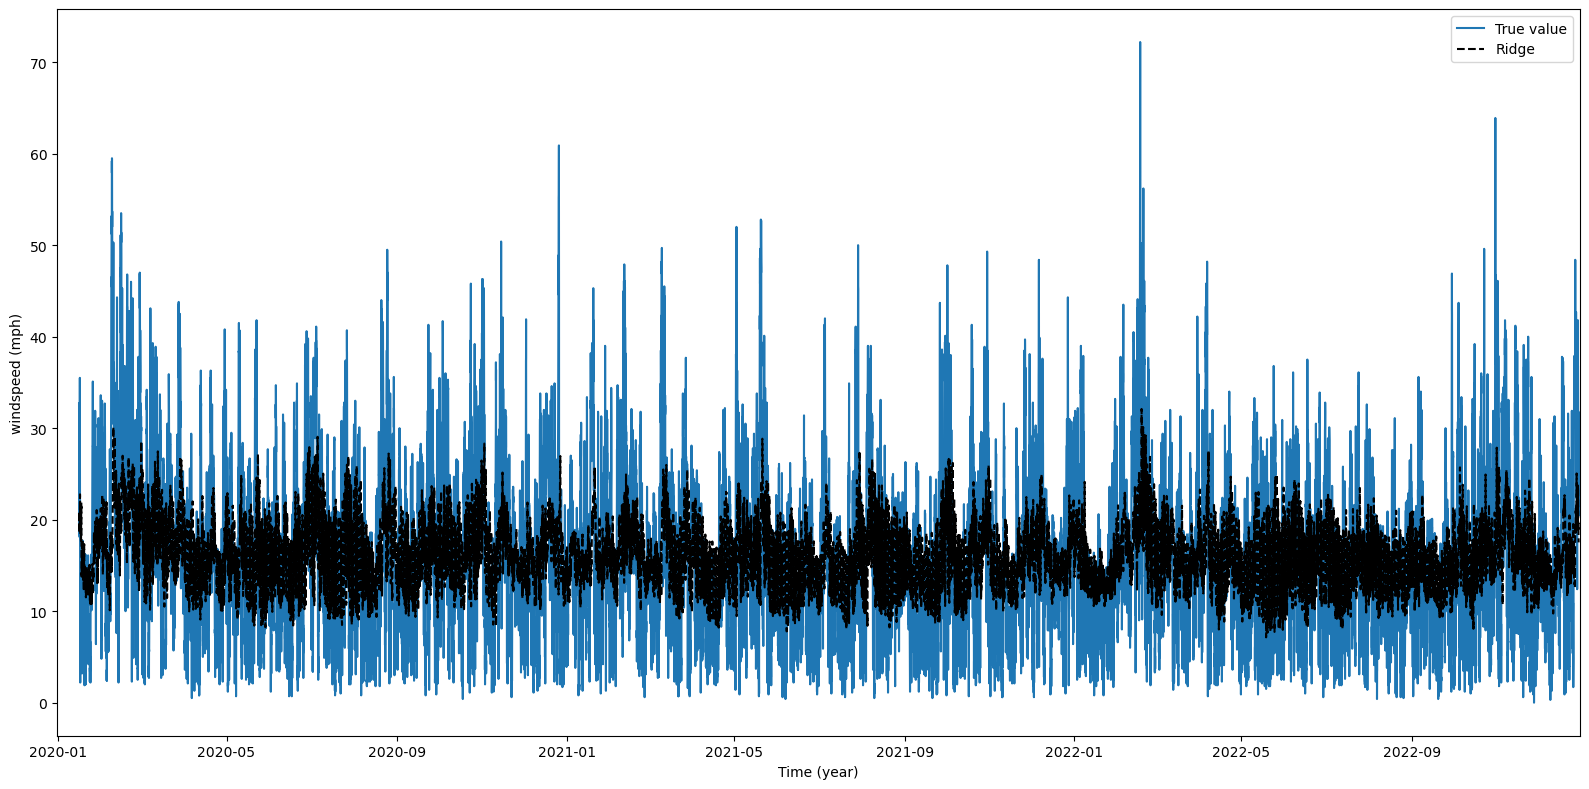

In [1637]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_valW.index, y_valW, label='True value')
ax.plot(y_valW.index, y_predW, '--', color='k', label='Ridge')
ax.set_xlabel('Time (year)')
ax.set_ylabel('windspeed (mph)')
_=ax.set_xlim(val_data.index.min(), val_data.index.max())
plt.legend(loc='best')
plt.tight_layout()

R2=0.18: This relatively low R2 score indicates that the model explains only 18% of the variance in wind speed in the validation dataset. This suggests that the model, while capturing some of the variability, is missing key aspects that influence wind speed changes.

MAE of 6.28 mph: An MAE of 6.28 mph is relatively high, considering the range and average speeds in the dataset, which might indicate that the model's predictions can be quite off from the actual values.

TESTING THE PERFORMANCE OF THE MODEL ON THE TEST DATASET

In [1638]:
y_predW2 = model.predict(X_testW)
measure_forecast_error2(y_testW, y_predW2)

MAE = 6.30 (mph)
R2 = 0.16


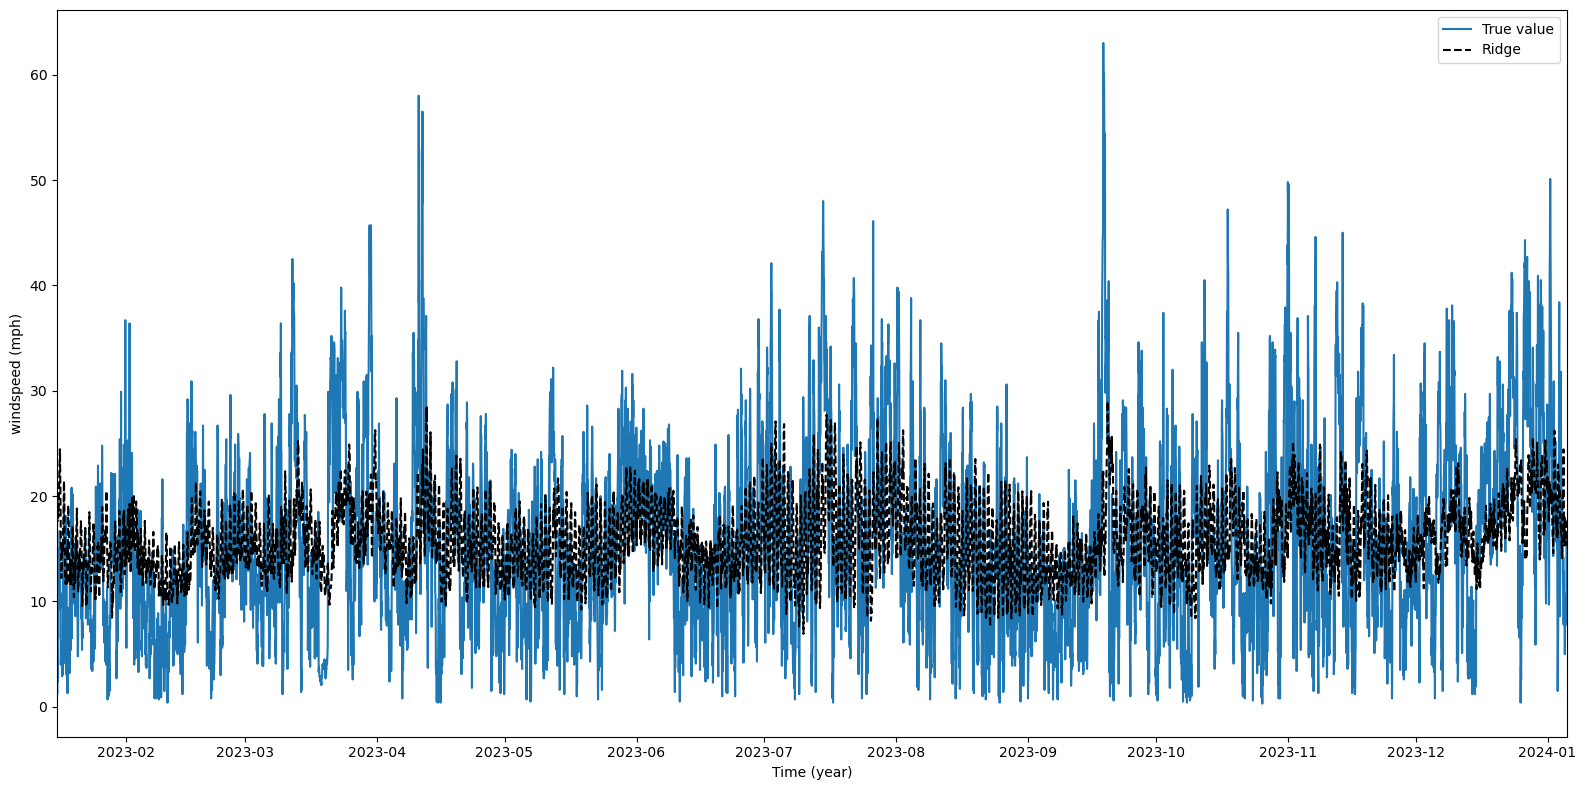

In [1639]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_testW.index, y_testW, label='True value')
ax.plot(y_testW.index, y_predW2, '--', color='k', label='Ridge')
ax.set_xlabel('Time (year)')
ax.set_ylabel('windspeed (mph)')
_=ax.set_xlim(y_testW.index.min(), y_testW.index.max())
plt.legend(loc='best')
plt.tight_layout()

R2 = 0.16: The R2 on the test dataset is slightly lower than on the validation set, which is typical as the test set might contain novel or more diverse scenarios not captured in the training or validation datasets. However, the consistent low R2 value across both datasets suggests systemic issues with the model's ability to predict wind speed.

MAE of 6.26 mph: Interestingly, the MAE is slightly lower in the test set compared to the validation set, which is unusual but might occur due to the specific distribution of wind speeds in the test data.

No data for December 2022
January 2023     -0.466143
February 2023     0.138245
March 2023        0.043665
April 2023        0.173381
May 2023          0.223416
June 2023         0.300631
July 2023         0.144820
August 2023       0.266232
September 2023    0.124842
October 2023      0.028174
November 2023     0.044929
December 2023    -0.077686
January 2024      0.027871
dtype: float64


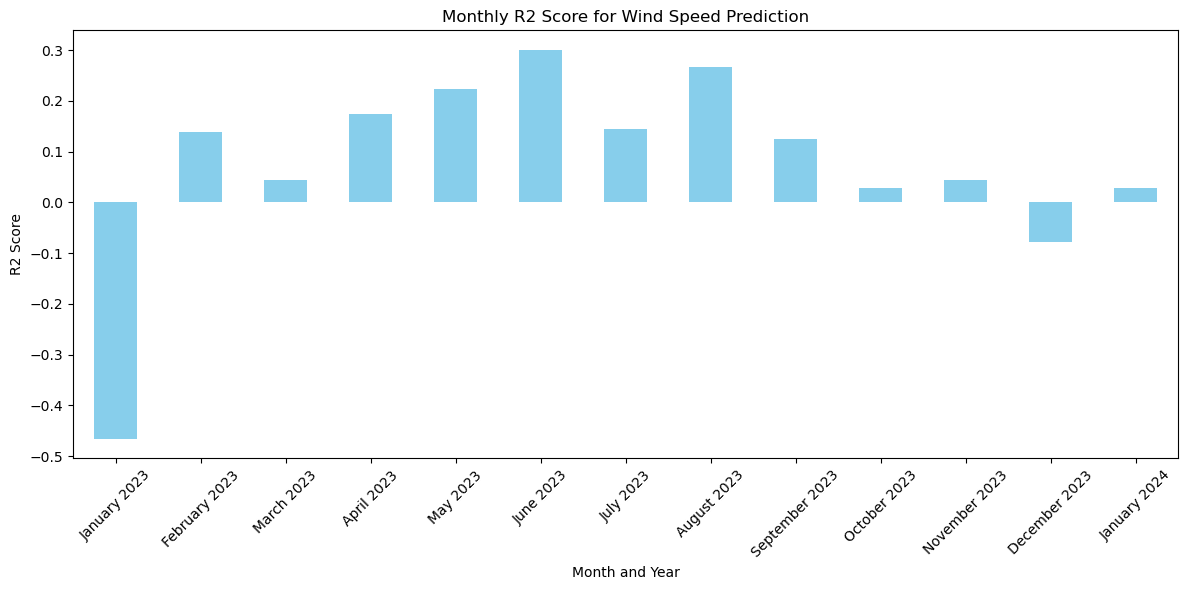

In [1640]:
# Create a list of monthly periods from the start to the end of your test data
monthly_periods = pd.period_range(start='2022-12-31 01:00:00', end='2024-01-06 11:00:00', freq='M')

# Dictionary to hold R2 for each month
monthly_r2 = {}

# Loop over each period
for period in monthly_periods:
    # Filter data for the current period
    month_data = windspeed_test[windspeed_test.index.to_period('M') == period]
    
    if not month_data.empty:
        # Assuming the target column is 'y' and is excluded from the prediction
        y_true = month_data['y']
        y_pred = model.predict(month_data.drop('y', axis=1))
        
        # Calculate and store R2
        monthly_r2[period.strftime('%B %Y')] = r2_score(y_true, y_pred)
    else:
        print(f"No data for {period.strftime('%B %Y')}")

# Convert to pandas Series for easy plotting and manipulation
monthly_r2_series = pd.Series(monthly_r2)
print(monthly_r2_series)

# Plotting
plt.figure(figsize=(12, 6))
monthly_r2_series.plot(kind='bar', color='skyblue')
plt.title('Monthly R2 Score for Wind Speed Prediction')
plt.xlabel('Month and Year')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust subplots to give some more room for the labels
plt.show()

PREDICTING WIND SPEED VALUES 24 HOURS IN ADVANCE 

In [1641]:
windspeed_test2 = test_data['windspeed'].copy().to_frame()
forecast_horizon = 24
window_size = 380
for lag in range(window_size):
    windspeed_test2[f'windspeed_lag{lag}'] = windspeed_test2['windspeed'].shift(lag+1)

windspeed_test2.dropna(inplace=True)
windspeed_test2 ['Final_Wind_Pred'] = model.predict(windspeed_test2)

windspeed_test2 ['Final_Wind_Pred'].tail(48)

2024-01-04 12:00:00    18.830891
2024-01-04 13:00:00    19.725151
2024-01-04 14:00:00    20.117363
2024-01-04 15:00:00    19.652469
2024-01-04 16:00:00    21.794969
2024-01-04 17:00:00    23.197502
2024-01-04 18:00:00    24.436800
2024-01-04 19:00:00    20.676408
2024-01-04 20:00:00    18.882514
2024-01-04 21:00:00    16.130252
2024-01-04 22:00:00    15.450108
2024-01-04 23:00:00    15.310280
2024-01-05 00:00:00    17.707220
2024-01-05 01:00:00    18.019724
2024-01-05 02:00:00    18.068299
2024-01-05 03:00:00    17.867478
2024-01-05 04:00:00    16.422932
2024-01-05 05:00:00    16.330169
2024-01-05 06:00:00    16.131793
2024-01-05 07:00:00    15.354513
2024-01-05 08:00:00    15.838357
2024-01-05 09:00:00    15.763572
2024-01-05 10:00:00    17.583450
2024-01-05 11:00:00    17.219317
2024-01-05 12:00:00    18.288340
2024-01-05 13:00:00    18.747281
2024-01-05 14:00:00    18.485982
2024-01-05 15:00:00    17.947358
2024-01-05 16:00:00    18.557090
2024-01-05 17:00:00    18.336994
2024-01-05